# Прикладные задачи анализа данных
## Генеративные сети

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).


Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?


## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.



#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!



Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

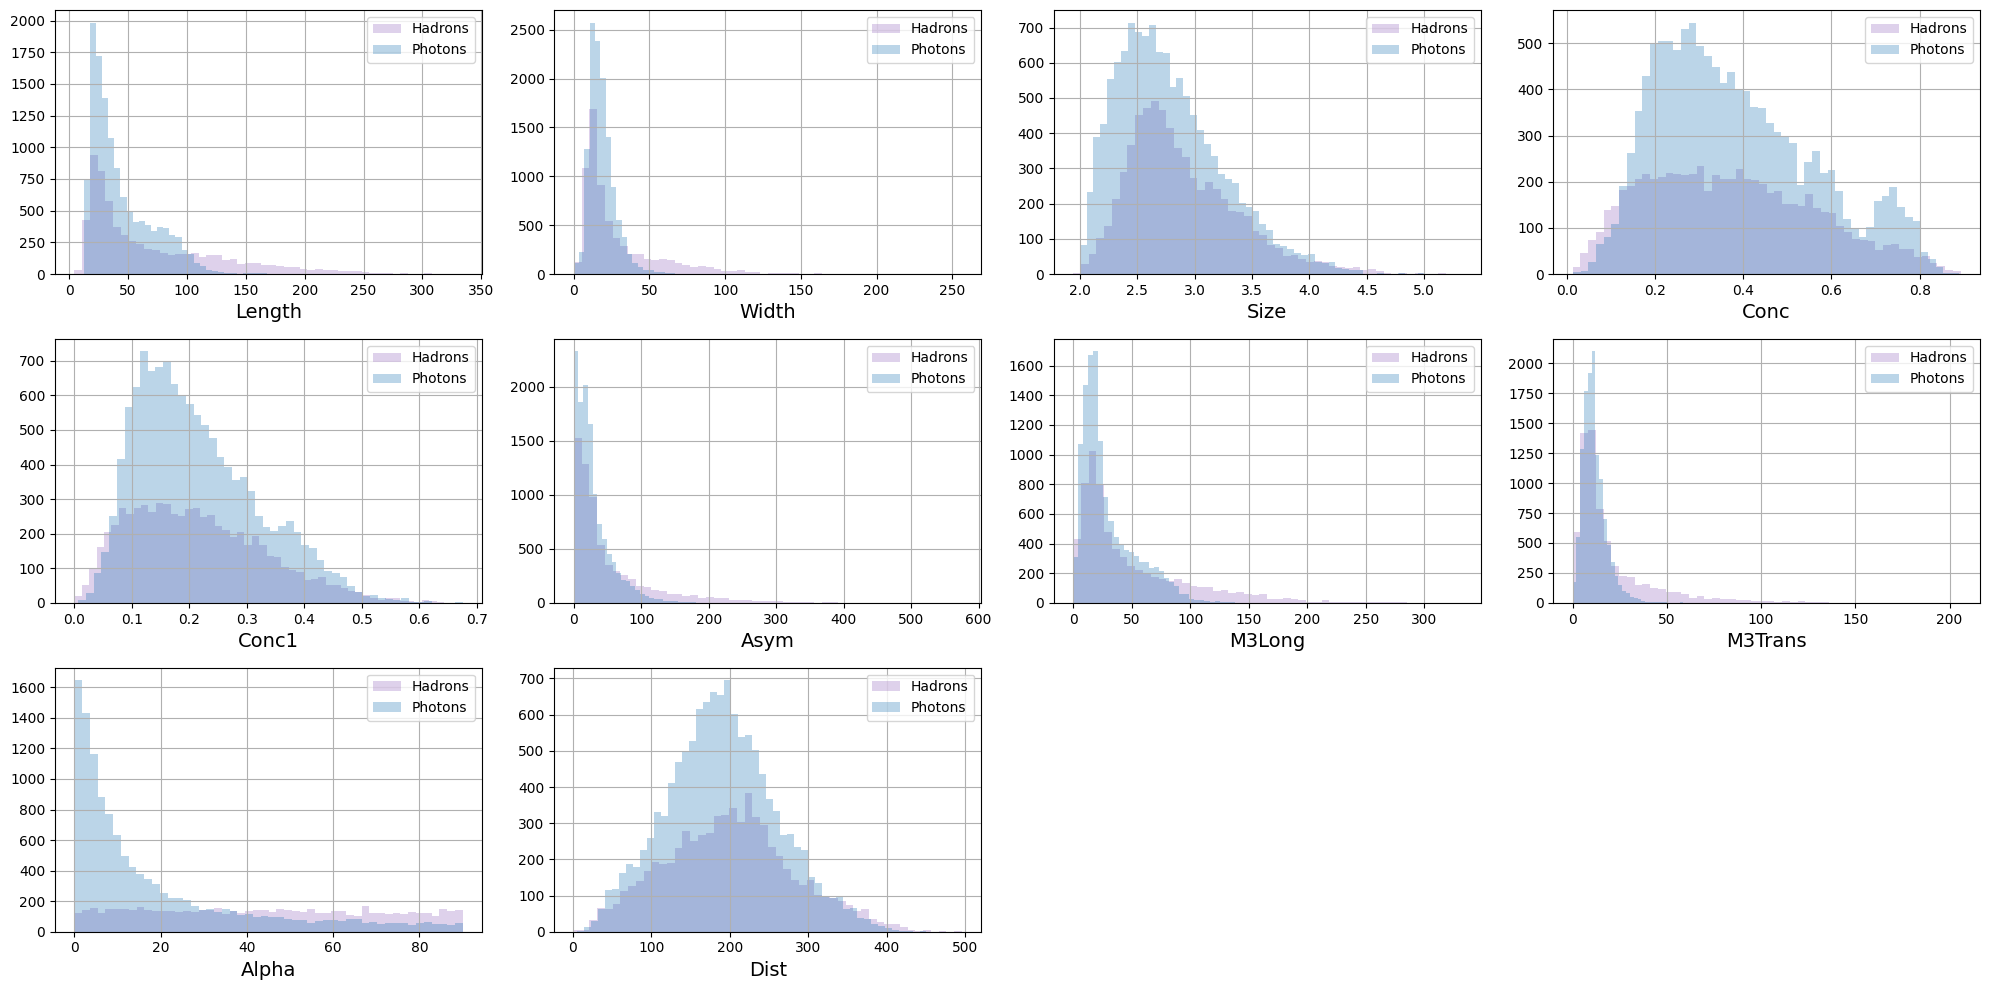

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

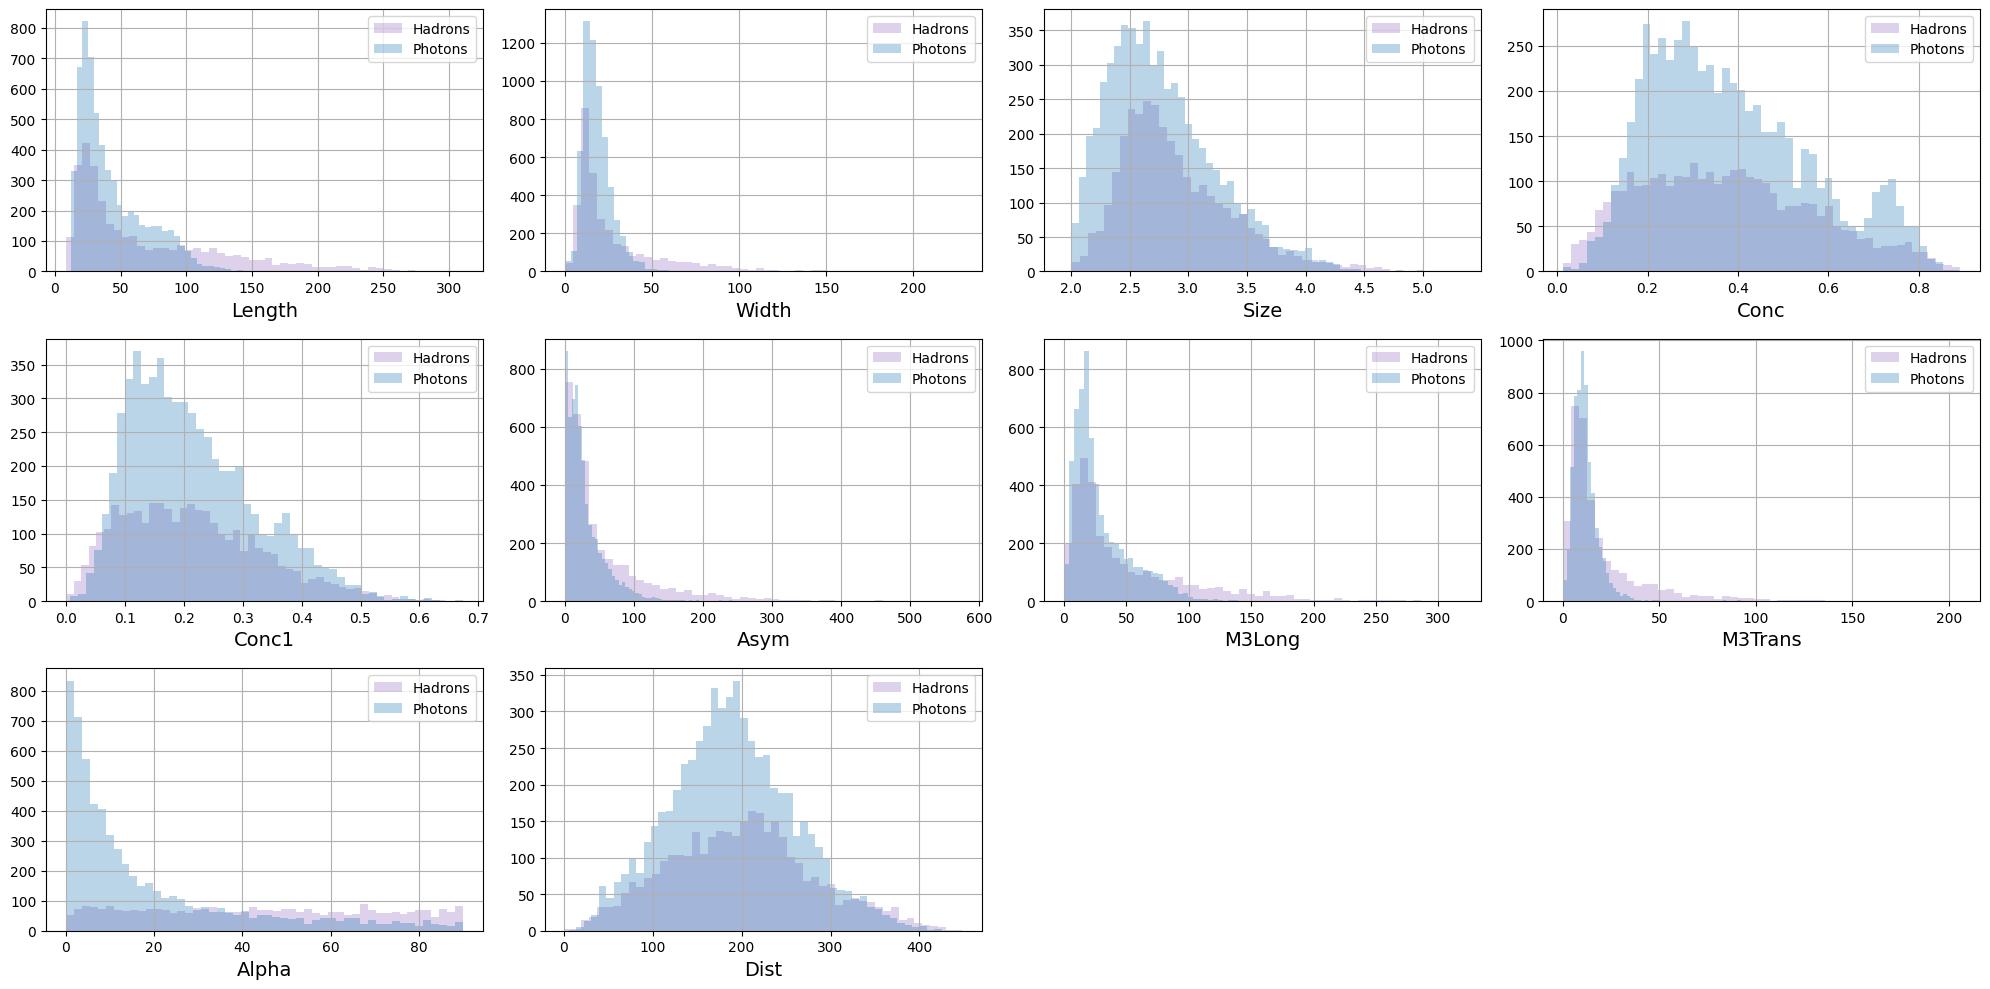

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

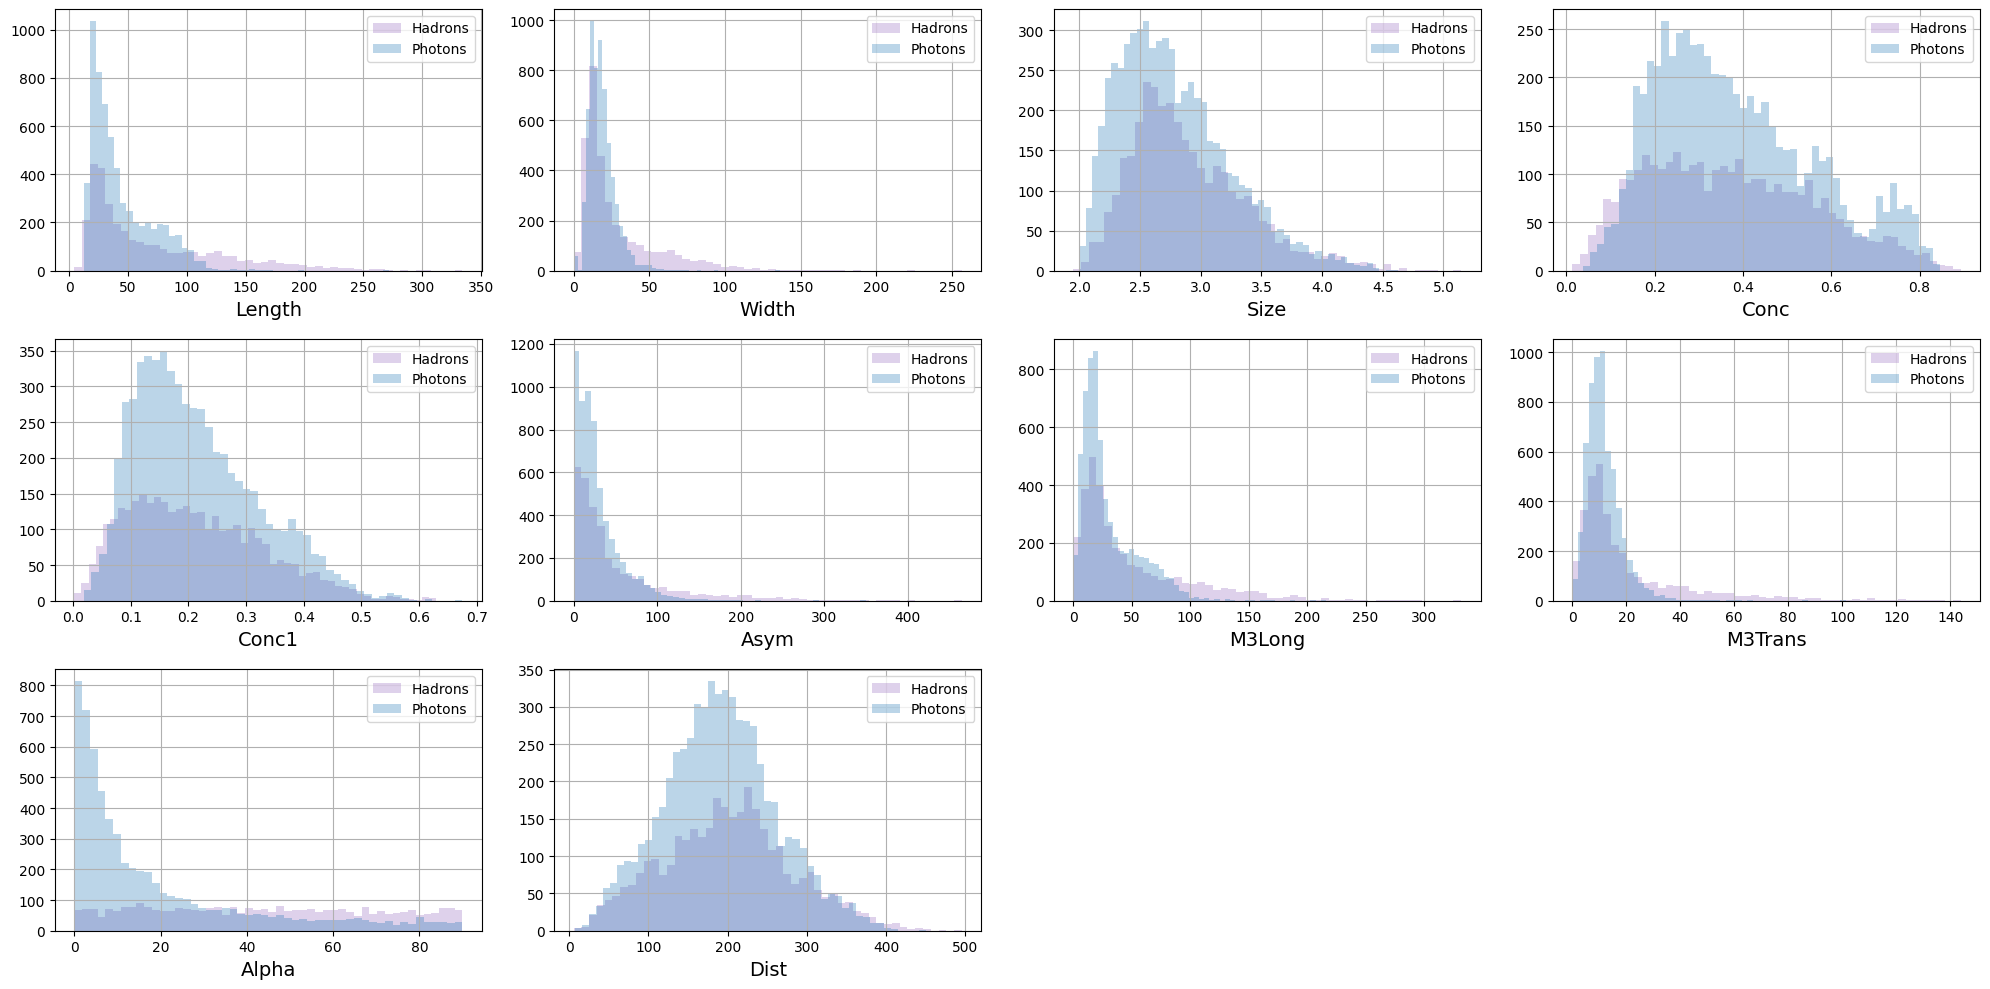

In [ ]:
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
qt = QuantileTransformer(output_distribution='normal')

In [ ]:
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

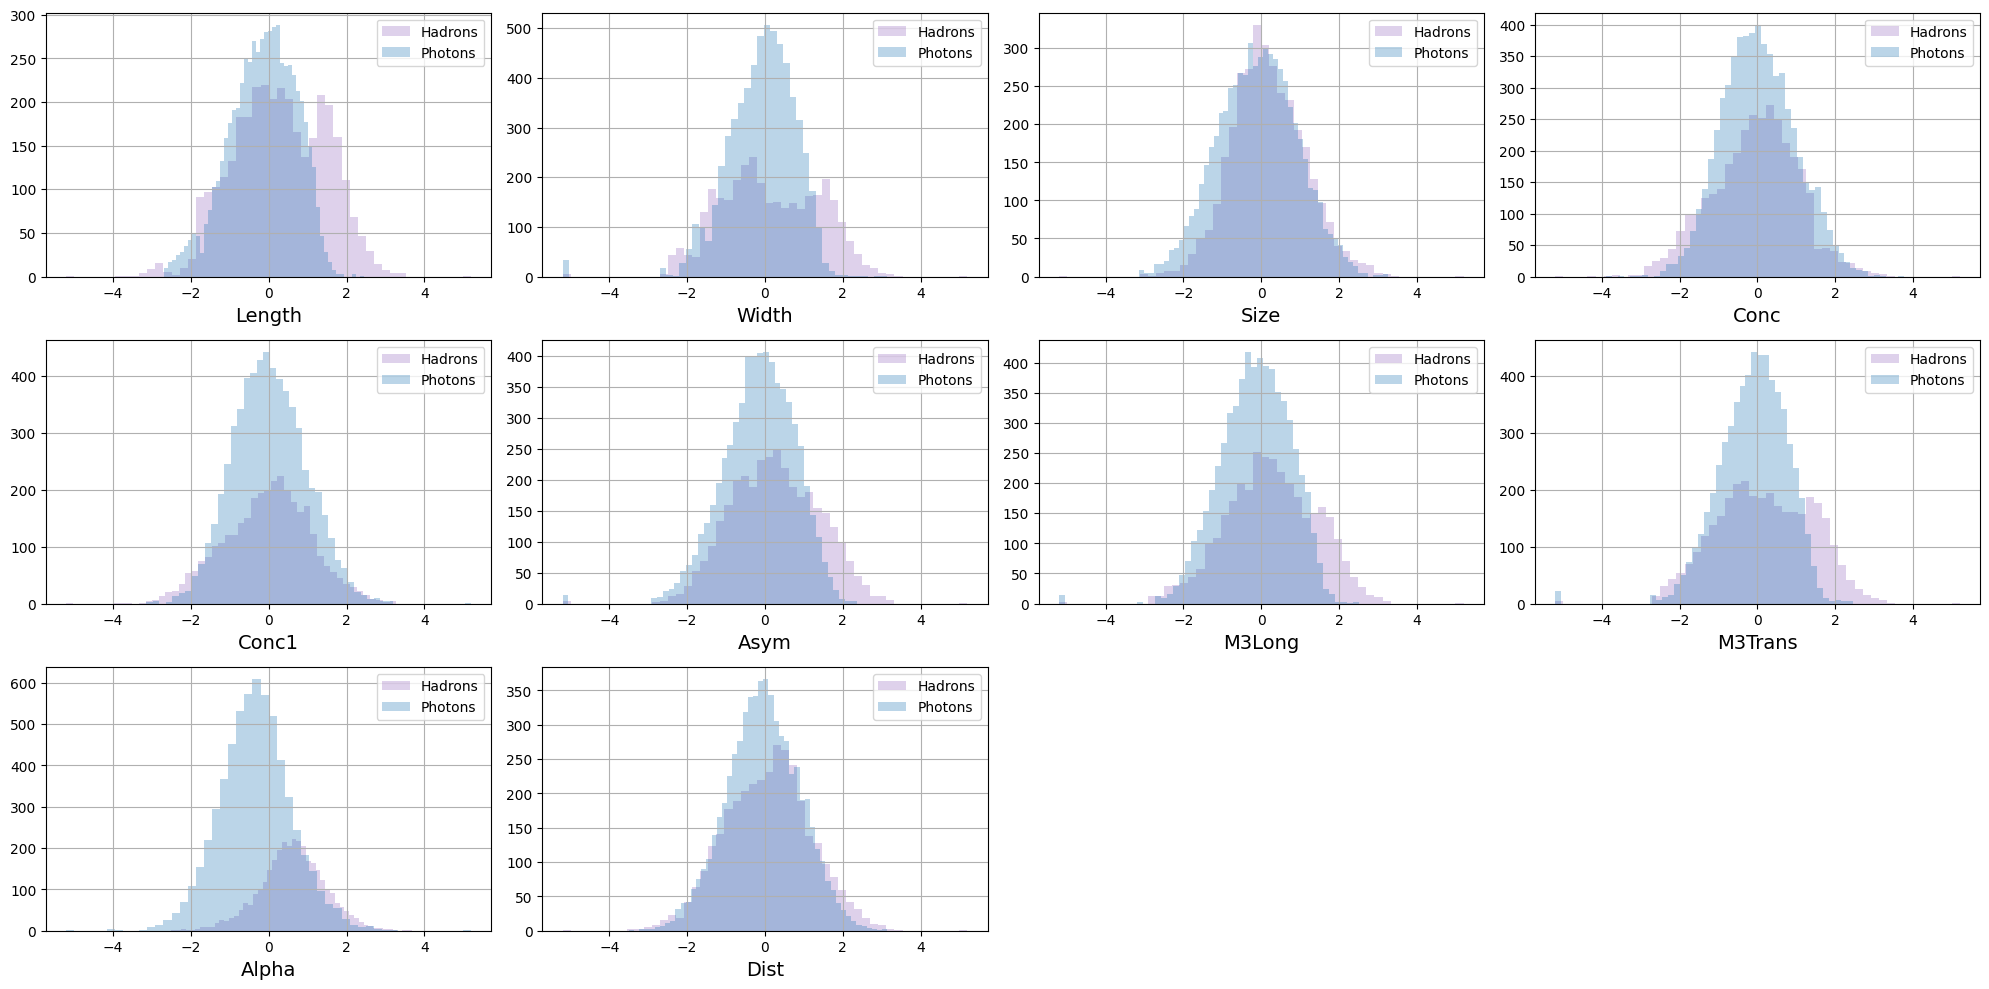

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

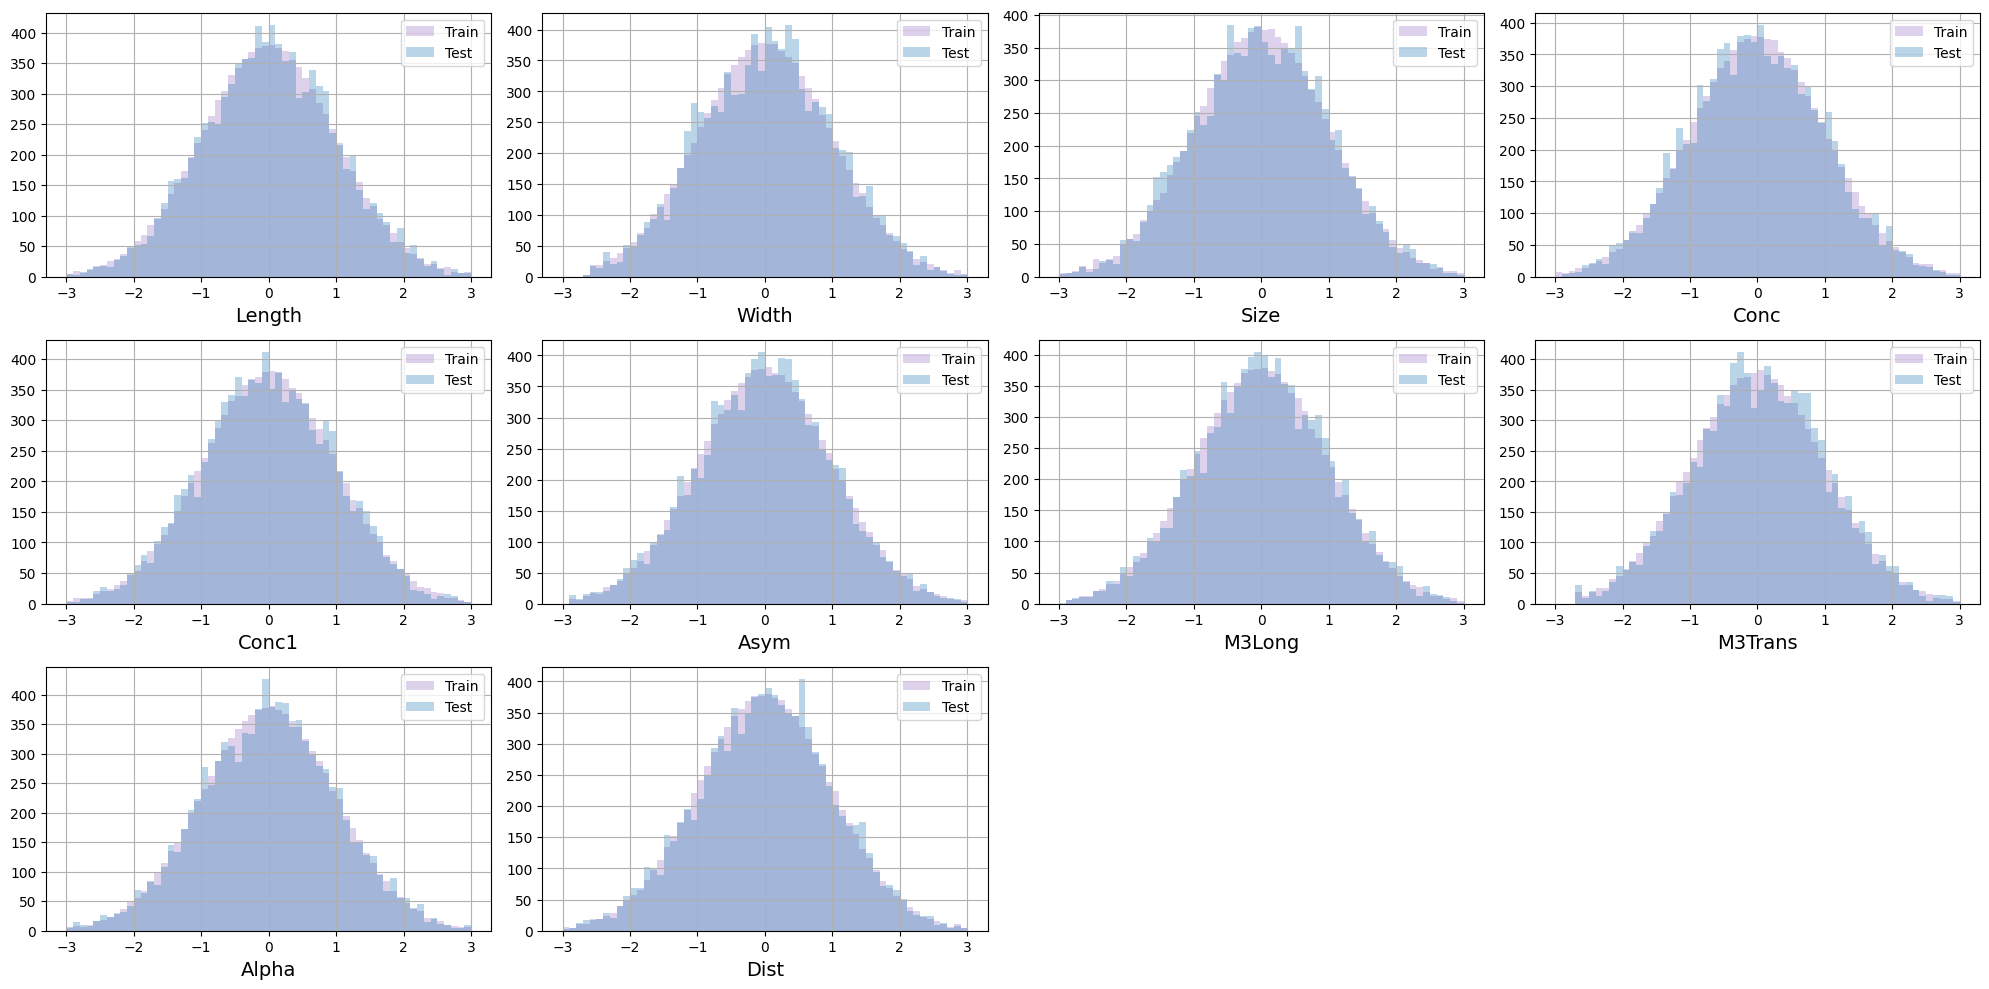

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.



Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.out = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        x = F.relu(self.bn1(self.fc1(zy)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.out(x)
        return x

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    generator.eval()

    num_samples = y.shape[0]

    z = torch.randn(num_samples, latent_dim)

    if y.ndim == 1:
        y = y.reshape(-1, 1)

    y = torch.from_numpy(y).float()

    z = z.to('cpu')
    y = y.to('cpu')

    with torch.no_grad():
        X_fake = generator(z, y)

    X_fake = X_fake.cpu().numpy()

    return X_fake


## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

Использование активатора в конце работы модели в данном случае не требуется, так как цель дискриминатора — оценить "водность" входных данных, что лучше всего делается с помощью выхода, который может принимать любые значения, а не ограничен диапазоном [0,1] как при использовании сигмоидальной функции активации

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.fc2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 1)

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        xy = torch.relu(self.fc1(xy))
        xy = torch.relu(self.fc2(xy))
        xy = self.out(xy)
        return xy

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
    log_reg.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, log_reg.predict(X_test))

    booster = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    booster.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, booster.predict(X_test))

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)

        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                for _ in range(self.n_critic):
                    Z_noise = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                    X_fake = self.generator(Z_noise, cond_batch)
                    disc_real = self.discriminator(real_batch, cond_batch)
                    disc_fake = self.discriminator(X_fake, cond_batch)
                    disc_loss = -(torch.mean(disc_real) - torch.mean(disc_fake))
                    self.opt_disc.zero_grad()
                    disc_loss.backward()
                    self.opt_disc.step()
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                Z_noise = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                X_fake = self.generator(Z_noise, cond_batch)
                gen_loss = -torch.mean(self.discriminator(X_fake, cond_batch))
                self.opt_gen.zero_grad()
                gen_loss.backward()
                self.opt_gen.step()

            Z_noise = torch.randn(len(X_real), self.latent_dim, device=DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            X_sample_real = X_real[:1000].cpu().numpy()
            y_sample_real = np.ones(1000)
            X_sample_fake = X_fake[:1000].detach().cpu().numpy()
            y_sample_fake = np.zeros(1000)
            other_agent_score(X_sample_real, y_sample_real, X_sample_fake, y_sample_fake)

        self.generator.train(False)
        self.discriminator.train(False)


## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.62
Boosting score: 0.758
Linear regression score: 0.532
Boosting score: 0.708
Linear regression score: 0.536
Boosting score: 0.702
Linear regression score: 0.592
Boosting score: 0.714
Linear regression score: 0.522
Boosting score: 0.688
Linear regression score: 0.59
Boosting score: 0.67
Linear regression score: 0.558
Boosting score: 0.664
Linear regression score: 0.578
Boosting score: 0.654
Linear regression score: 0.526
Boosting score: 0.65
Linear regression score: 0.56
Boosting score: 0.64
Linear regression score: 0.632
Boosting score: 0.694
Linear regression score: 0.552
Boosting score: 0.674
Linear regression score: 0.516
Boosting score: 0.676
Linear regression score: 0.54
Boosting score: 0.638
Linear regression score: 0.516
Boosting score: 0.642
Linear regression score: 0.532
Boosting score: 0.666
Linear regression score: 0.546
Boosting score: 0.66
Linear regression score: 0.542
Boosting score: 0.658
Linear regression score: 0.55
Boosting score: 0.59
Lin

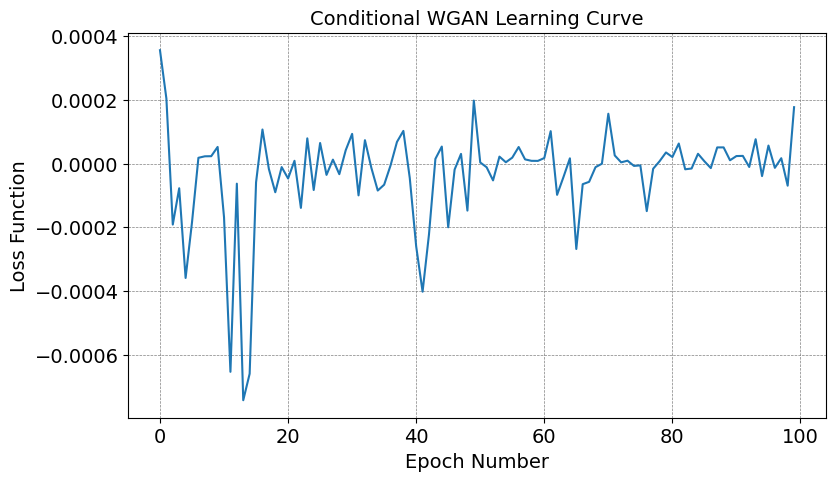

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
 y_train

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

In [ ]:
X_fake_train_inverse = qt.inverse_transform(X_fake_train)

In [ ]:
X_train_inverse = qt.inverse_transform(X_train)

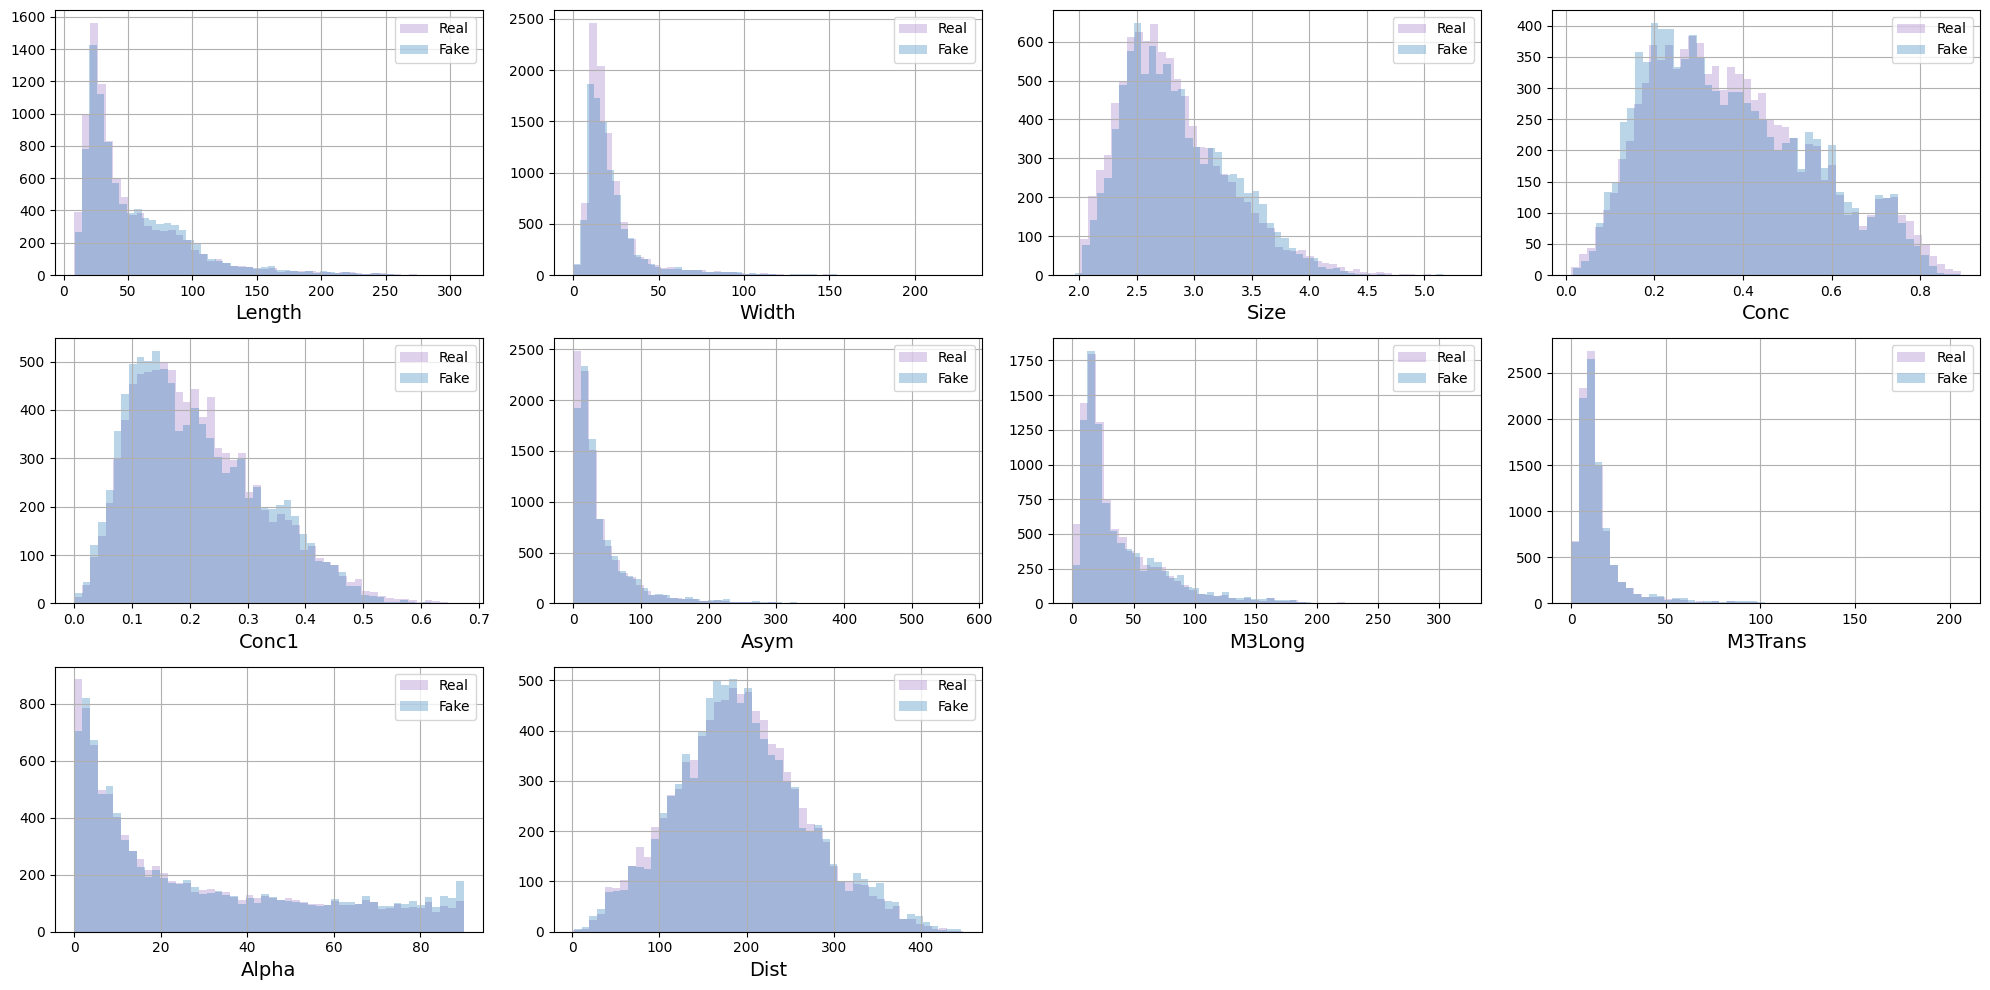

In [ ]:
plot_hists(X_train_inverse, X_fake_train_inverse, names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

In [ ]:
X_fake_test_inverse = qt.inverse_transform(X_fake_test)

In [ ]:
X_test_inverse = qt.inverse_transform(X_test)

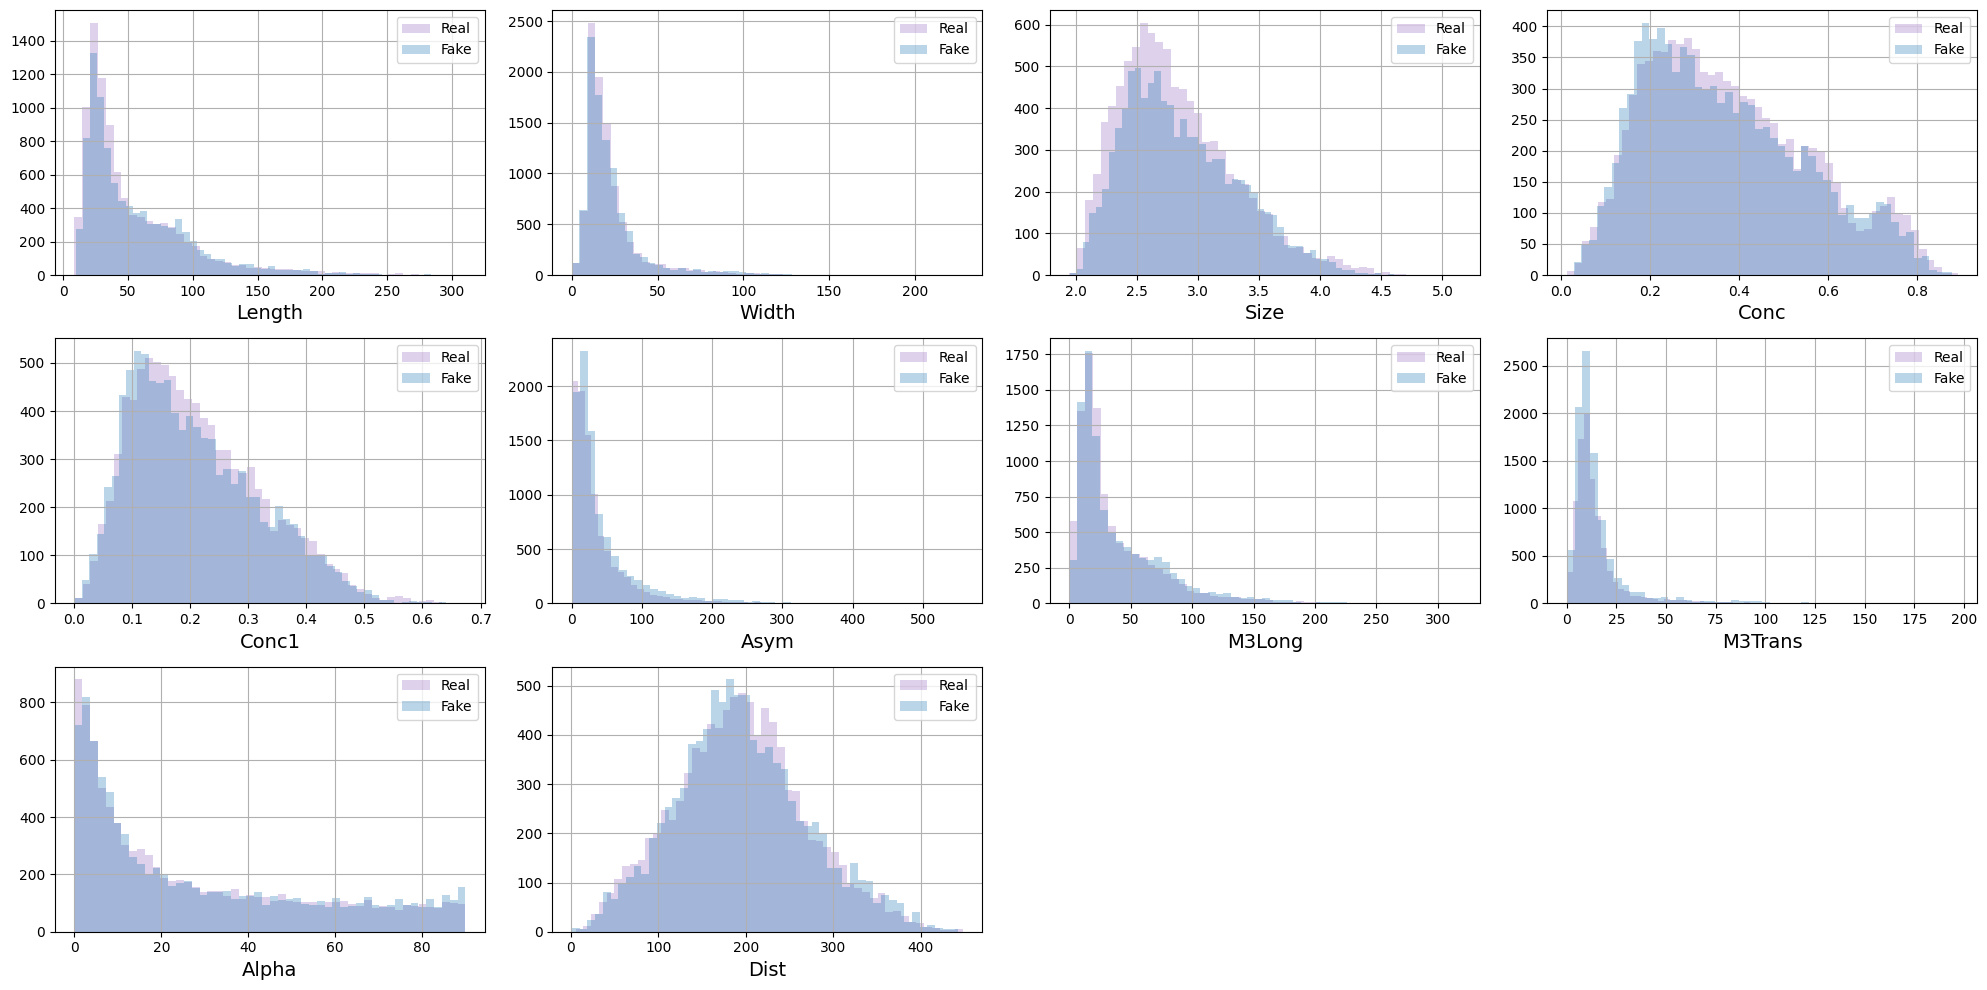

In [ ]:
plot_hists(X_test_inverse, X_fake_test_inverse, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации



Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7070402564791503


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Сначала я сделал глупость и проинверсил только один параметр, отсюда распределения практически не совпадали и отсюда получился бы ROC AUC 1. Потом когда я сделал инверс для двух выборок, то они уже практически совпали и ROC AUC стал человечнее =  0.74.

Это говорит о том, что наш классификатор может различать реальные и сгенерированные объекты лучше, чем случайный выбор, но всё же далек от идеального различения. Идеальным сценарием для генеративной модели было бы значение ROC AUC, равное 0.5. Это означало бы, что сгенерированные данные настолько похожи на реальные, что классификатор не может их различить лучше, чем наугад. Таким образом, чем ближе значение ROC AUC к 0.5, тем выше качество генерации данных моделью

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
    noise = amount * np.random.randn(*x.shape)
    x_noisy = x + noise
    x_noisy = np.clip(x_noisy, 0, 1)
    return x_noisy

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers

In [ ]:
from diffusers import DDPMScheduler

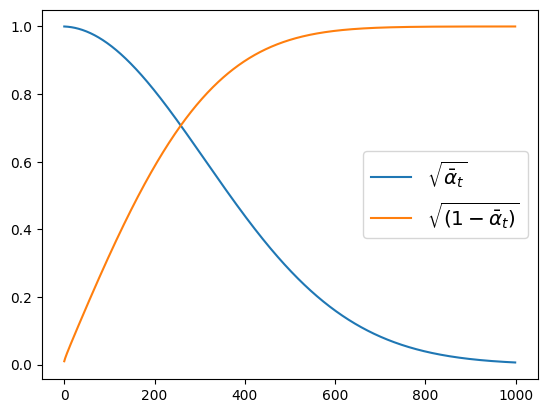

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

Оценка качества сгенерированных объектов часто включает сравнение распределений реальных и сгенерированных данных (по аналогии с тем как мы делали ранее). ROC AUC близкий к 0.5 может свидетельствовать о высоком качестве генерации (о чем я писал ранее), поскольку классификатор не может отличить сгенерированные данные от настоящих. Другие способы включают в себя визуальное сравнение, использование метрик типа Inception Score (IS) и Frechet Inception Distance (FID) для изображений, и сравнение статистических свойств распределений.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.relu2 = nn.ReLU()

        self.out = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        zy = self.relu1(self.bn1(self.fc1(zy)))
        zy = self.relu2(self.bn2(self.fc2(zy)))
        zy = self.out(zy)
        return zy

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    if isinstance(y, np.ndarray):
      y = torch.tensor(y, dtype=torch.float32, device="cpu")
    else:
      y = y.to("cpu")

    z = torch.randn(y.size(0), latent_dim, device="cpu")

    for t in reversed(range(scheduler.num_train_timesteps)):
        z = model(z, y)
    X_fake = z.detach().cpu().numpy()
    return X_fake


## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        dataset_real = TensorDataset(X_real, y_cond)

        self.model.train(True)

        self.loss_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                for _ in range(self.n_critic):
                    self.opt_gen.zero_grad()

                    Z_noise = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)

                    generated_data = self.model(Z_noise, cond_batch)

                    loss = torch.nn.functional.mse_loss(generated_data, real_batch)
                    loss.backward()
                    self.opt_gen.step()

                    loss_epoch += loss.item()


            self.loss_history.append(loss_epoch)

            X_sample_real = X_real[np.random.choice(len(X_real), 1000, replace=False)].cpu().numpy()
            y_sample_real = y_cond[np.random.choice(len(X_real), 1000, replace=False)].cpu().numpy().ravel()

            Z_noise = torch.randn(1000, self.latent_dim, device=DEVICE)
            y_sample_fake = torch.zeros(1000, 1, device=DEVICE)
            X_sample_fake = self.model(Z_noise, y_sample_fake).detach().cpu().numpy()

            other_agent_score(X_sample_real, y_sample_real, X_sample_fake, y_sample_fake.cpu().numpy().ravel())

        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.67
Boosting score: 0.794
Linear regression score: 0.678
Boosting score: 0.77
Linear regression score: 0.686
Boosting score: 0.784
Linear regression score: 0.666
Boosting score: 0.796
Linear regression score: 0.674
Boosting score: 0.802
Linear regression score: 0.672
Boosting score: 0.822
Linear regression score: 0.668
Boosting score: 0.812
Linear regression score: 0.672
Boosting score: 0.77
Linear regression score: 0.688
Boosting score: 0.804
Linear regression score: 0.666
Boosting score: 0.776
Linear regression score: 0.674
Boosting score: 0.784
Linear regression score: 0.676
Boosting score: 0.78
Linear regression score: 0.688
Boosting score: 0.79
Linear regression score: 0.682
Boosting score: 0.806
Linear regression score: 0.676
Boosting score: 0.778
Linear regression score: 0.678
Boosting score: 0.778
Linear regression score: 0.676
Boosting score: 0.8
Linear regression score: 0.69
Boosting score: 0.786
Linear regression score: 0.678
Boosting score: 0.802
L

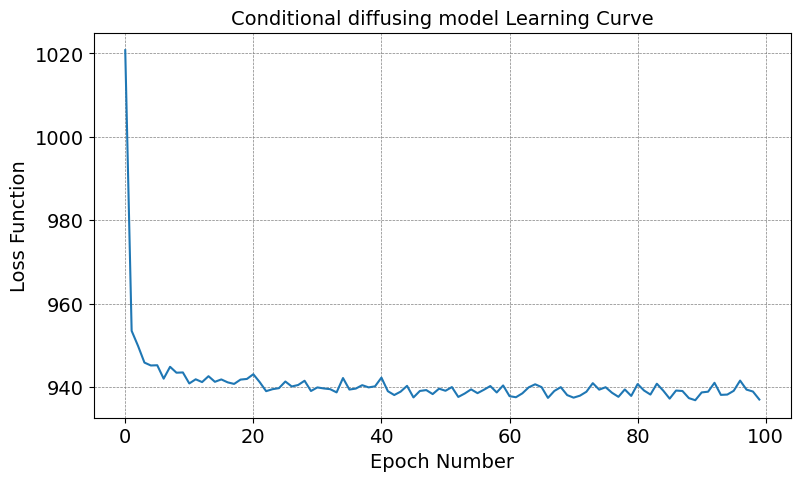

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [ ]:
scheduler = DDPMScheduler(num_train_timesteps=1000)

Добавлю функцию, которая будет генерить выборку по частям, а не сразу 1000. Когда делал сразу 1000, то превышало объем памяти и ложился блокнот

In [ ]:
def generate_in_parts(model, y, latent_dim, scheduler, parts=10):
    part_size = len(y) // parts
    generated_data = []
    for i in range(parts):
        start = i * part_size
        end = (i + 1) * part_size if i < parts - 1 else len(y)
        y_part = y[start:end]
        generated_part = generate_with_diffusion(model, y_part, latent_dim, scheduler)
        generated_data.append(generated_part)
    return np.concatenate(generated_data, axis=0)

In [ ]:
X_fake_train = generate_in_parts(
    model=diffusionFitter.model,
    y=y_train,
    latent_dim=latent_dim,
    scheduler=scheduler,
    parts=10
)


X_fake_train_inverse = qt.inverse_transform(X_fake_train)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
X_fake_test = generate_in_parts(
    model=diffusionFitter.model,
    y=y_test,
    latent_dim=latent_dim,
    scheduler=scheduler,
    parts=10
)


X_fake_test_inverse = qt.inverse_transform(X_fake_test)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


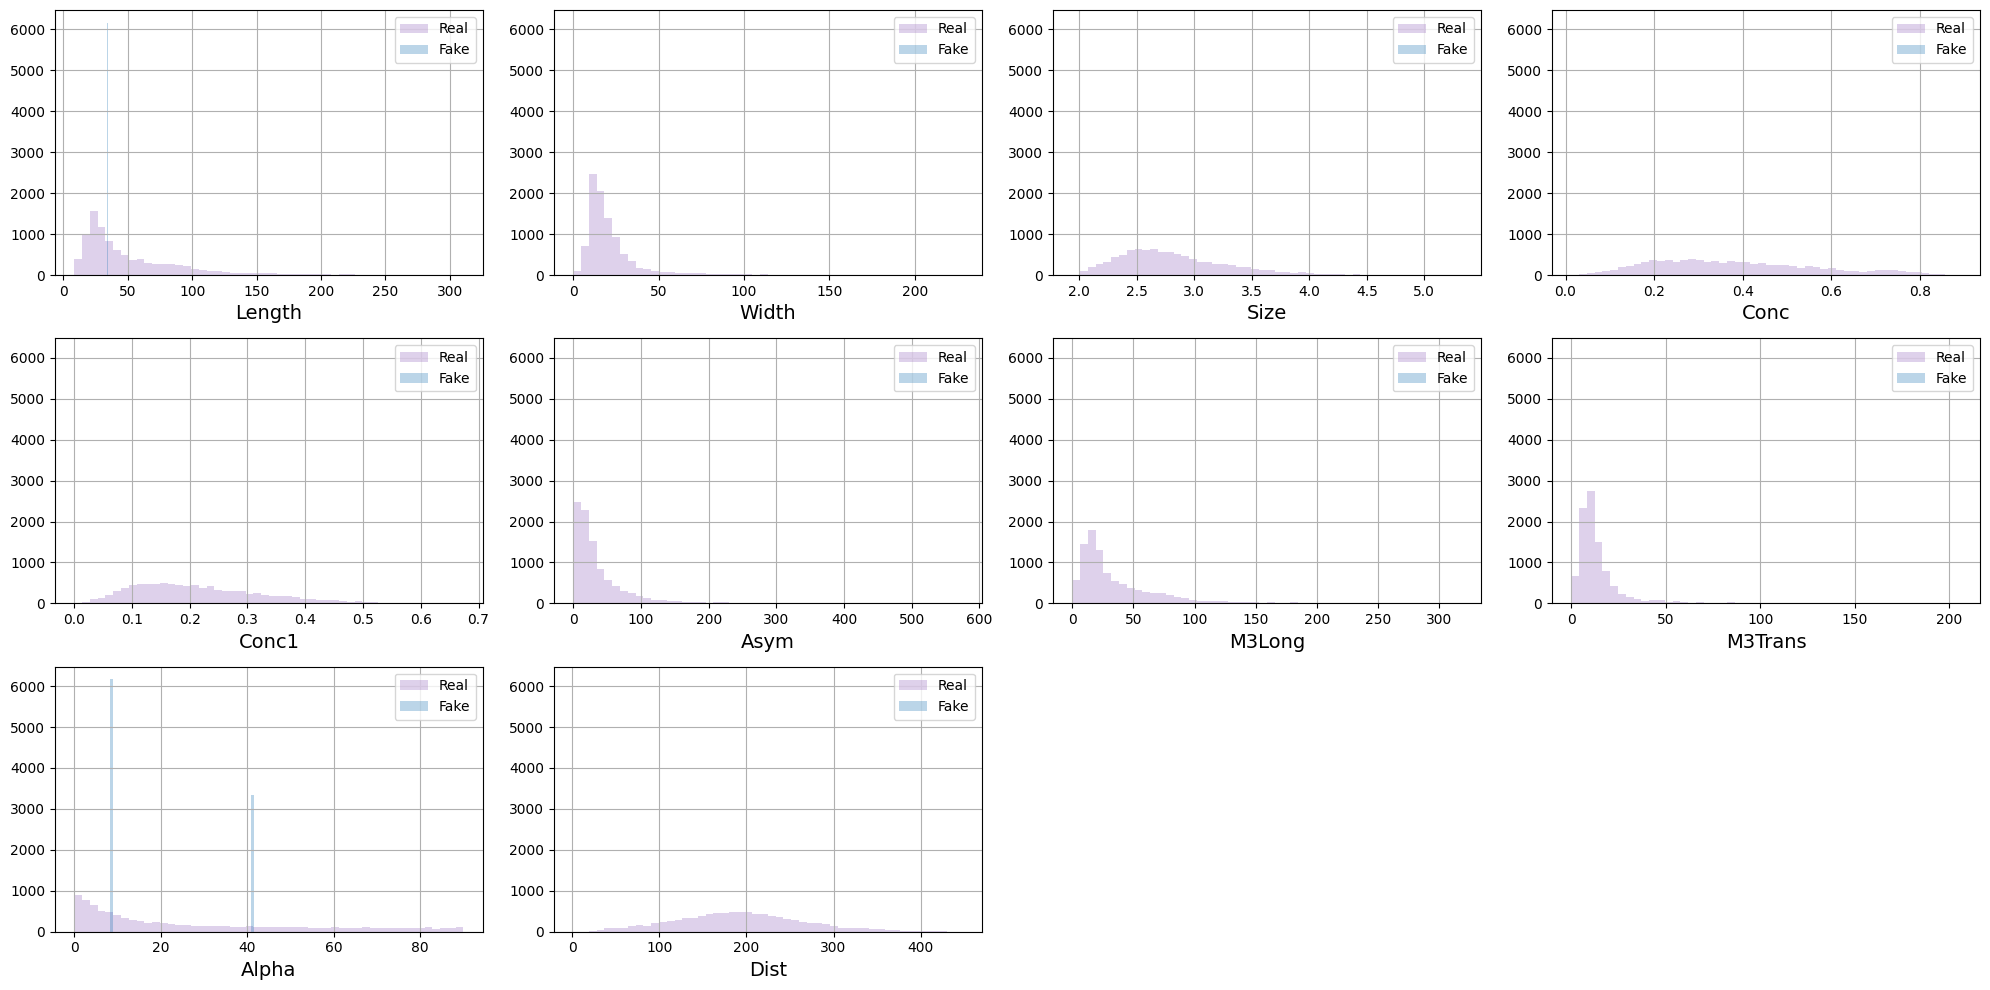

In [ ]:
plot_hists(X_train_inverse, X_fake_train_inverse, names, label1="Real", label2="Fake", bins=50)

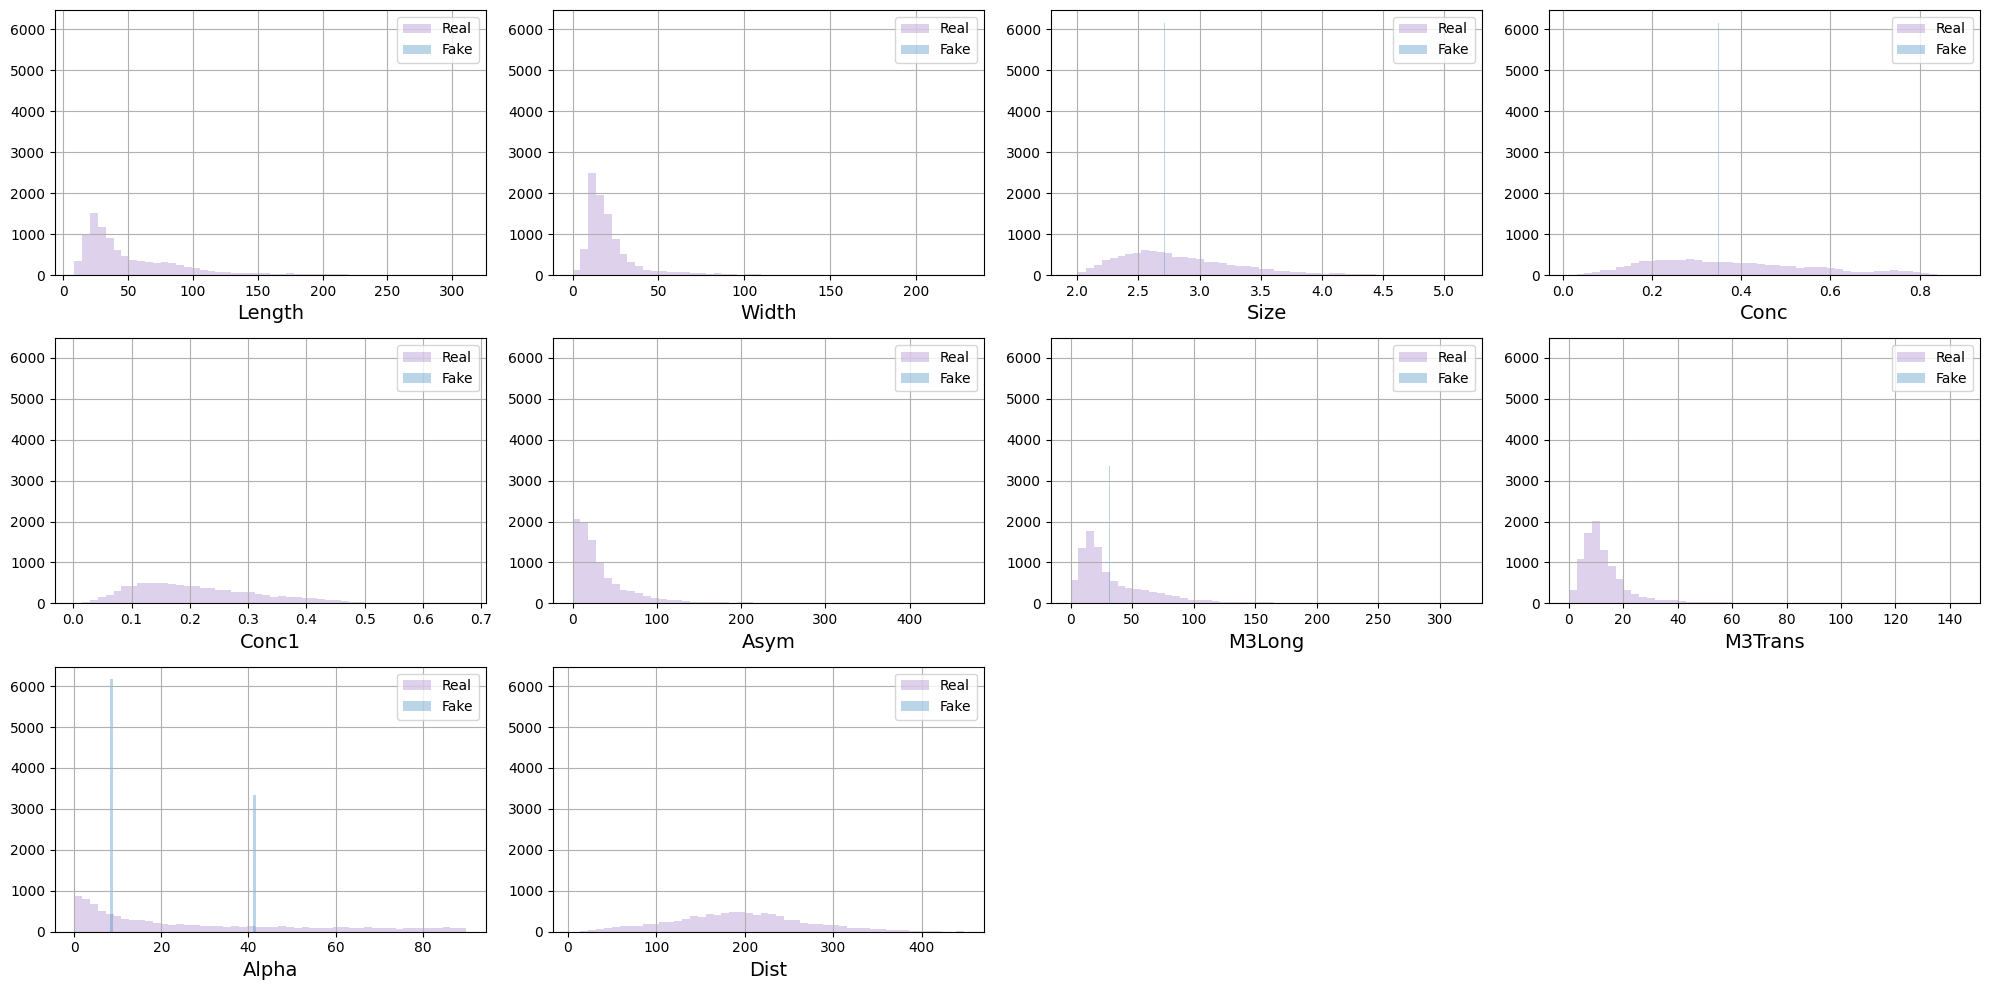

In [ ]:
plot_hists(X_test_inverse, X_fake_test_inverse, names, label1="Real", label2="Fake", bins=50)

In [ ]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  1.0


Видно что рок аук вышел 1. Это достаточно странно, но если интерпритировать даже такой результат, то видно, что наш генератор очень далек от идеала, так как со сто процентной вероятностью различает сгенерированные данные, что является плохим показателем, в отличие от его предшественника из прошлых заданий